# Deep Learning & Art: Neural Style Transfer


**In this project, I will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images
- Fine tune hyper-parameters to get more pleasing 'arts'


In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline
print(tf.__version__)

from Neural_Style_Transfer_utils import *
import imageio
import time
import glob # serach under a foler

1.15.0


## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="good/demo2.png" style="width:750px;height:600px;">

Let's see how you can do this. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the [original NST paper](https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 
<img src="good/VGG19.png" style="width:700px;height:300px;">


In [2]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)


{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256)

## 3 - Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - define main function

The following main function hard code the important hyper parameters: stye_coef, STYLE_LAYERS, content_cost_layer. I will demostrate them later.

In [3]:
#%% main f
def NST_main(model, folder_in, folder_out, image_C, image_S, S_weit ='up', N = 200):    
    #% initial important hyper-param
    stye_coef = 40 # (0 ~ infinity), it in fact does not affct much of generated images
    
    S_weight={} # dict
    S_weight['eq'] = [
        ('conv1_1', 0.2),
        ('conv2_1', 0.2),
        ('conv3_1', 0.2),
        ('conv4_1', 0.2),
        ('conv5_1', 0.2)]
    S_weight['up']  = [
        ('conv1_1', 0.01),
        ('conv2_1', 0.1),
        ('conv3_1', 0.2),
        ('conv4_1', 0.3),
        ('conv5_1', 0.4)]
    S_weight['dn'] = [
        ('conv1_1', 0.4),
        ('conv2_1', 0.3),
        ('conv3_1', 0.2),
        ('conv4_1', 0.1),
        ('conv5_1', 0.01)]

    STYLE_LAYERS = S_weight[S_weit]

    # S_weit = 'eq' # 'eq', 'up', 'dn'
    content_cost_layer = 'conv4_2' # default = 'conv4_2'
    image_C_name = image_C.replace(".jpg","")
    save_dir = folder_out +"/"+ image_C_name + "_" +content_cost_layer+S_weit +"_" # "output_up/5L2_"


    #% laod images
    content_image = imageio.imread(os.path.join(folder_in,image_C))
    plt.figure()
    imshow(content_image)
    content_image = reshape_and_normalize_image(content_image)
    
    # style_image = imageio.imread(os.path.join(folder_in, image_S))
    style_image = imageio.imread( image_S)
    plt.figure()
    imshow(style_image)
    style_image = reshape_and_normalize_image(style_image)
    
    # initial generate image:
    generated_image = generate_noise_image(content_image)
    plt.figure()
    imshow(generated_image[0])
      
    
    #% initial model input
    # Start interactive session
    sess = tf.InteractiveSession()
    
    # Assign the content image to be the input of the VGG model.  
    sess.run(model['input'].assign(content_image))
    
    # Select the output tensor of layer conv4_2
    out = model[content_cost_layer]
    
    # Set a_C to be the hidden layer activation from the layer we have selected
    a_C = sess.run(out)
    
    # Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
    # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
    # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
    a_G = out
    
    
    # Compute the content cost
    J_content = compute_content_cost(a_C, a_G)
    
    # Assign the input of the model to be the "style" image 
    sess.run(model['input'].assign(style_image))
    
    # Compute the style cost
    J_style = compute_style_cost(sess, model, STYLE_LAYERS)
    
    J =  total_cost(J_content, J_style,  alpha = 1, beta = stye_coef)
    
    cache = (J, J_content, J_style) # tuple, to be used by model_nn
    #% train model
    # define optimizer (1 line)
    optimizer = tf.train.AdamOptimizer(2.0)
    
    # define train_step (1 line)
    train_step = optimizer.minimize(J)
    
    # generate an artistic image. It should take about 3min on CPU for every 20 iterations but you start observing attractive results after ≈140 iterations
    _, history_cost=model_nn(sess, model, cache, train_step, generated_image, num_iterations = N, output_dir=save_dir)
    sess.close() # Otherwise, another active session may lead to OOM error when run many times
    
    # show generated_image
    Ct = history_cost['total']
    Cc = history_cost['content']
    Cs = history_cost['style']
    
    plt.figure(figsize=(10,6))
    plt.plot(Cc,'o-', linewidth=2, markersize=5, label='content')
    plt.plot(Cs,'o-', linewidth=2, markersize=5, label='style')
    plt.plot(Ct,'o--', linewidth=2, markersize=5, label='total')
    plt.yscale('symlog')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.grid(True)
    plt.ylabel("Cost") 
    plt.xlabel("every 50 epochs") 
    
    plt.savefig(save_dir + 'cost.png')

### 3.2 - Hyper parameters

- stye_coef:
It (i.e., $\alpha/\beta$) decide how much the generated image will looks like the style image. A relative large value allows fast learning. default = 40. 
- STYLE_LAYERS: we combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `S_weight`.

- content_cost_layer: default = 'conv4_2'

We use an example to show the effect of hyper parameters.

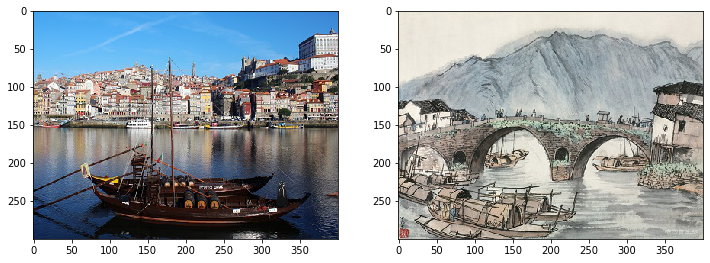

In [4]:
#%% plot content image and style image
out_image1 = imageio.imread("demo_photos\portogal2.jpg")
out_image2 = imageio.imread("image_style\shanshui3.jpg")

fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].imshow(out_image1)
axs[1].imshow(out_image2)

After 2000 iterations (~10 mins for each image), we got the following generated images with the content layer as layer 3, 4 or 5 with two ways of style image weighting: up and dn.
It turns out that such traditional chinese painting style is the most difficult to learn due to a large empty space and highly abstract painting. 

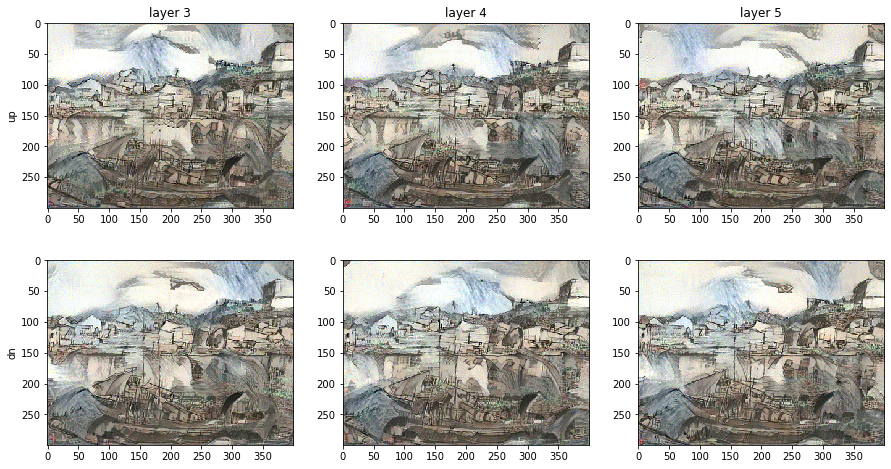

In [5]:
#%% comparing hyper-parameters amonst 6 figs
outpath = "good/portogal2_"
out_image00 = imageio.imread(outpath+"conv3_2up_2000.png")
out_image01 = imageio.imread(outpath+"conv4_2up_2000.png")
out_image02 = imageio.imread(outpath+"conv5_2up_2000.png")
out_image10 = imageio.imread(outpath+"conv3_2dn_2000.png")
out_image11 = imageio.imread(outpath+"conv4_2dn_2000.png")
out_image12 = imageio.imread(outpath+"conv5_2dn_2000.png")

fig, axs = plt.subplots(2, 3, figsize=(15,8))
axs[0, 0].imshow(out_image00)
axs[0, 0].set_title('layer 3')
axs[0, 0].set_ylabel('up')
axs[0, 1].imshow(out_image01)
axs[0, 1].set_title('layer 4')
axs[0, 2].imshow(out_image02)
axs[0, 2].set_title('layer 5')
axs[1, 0].imshow(out_image10)
axs[1, 0].set_ylabel('dn')
axs[1, 1].imshow(out_image11)
axs[1, 2].imshow(out_image12)

## 4 - Try it on one pair of images

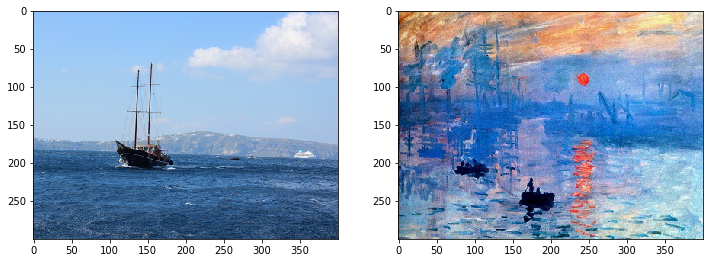

In [6]:
#%% plot content image and style image
out_image1 = imageio.imread("demo_photos\greece.jpg")
out_image2 = imageio.imread("image_style\Monet.jpg")

fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].imshow(out_image1)
axs[1].imshow(out_image2)

In [7]:
#%% start processing images & save generated images in folder_out
folder_in = "demo_photos"
image_C = "greece.jpg"
image_S = "image_style\\Monet.jpg"
folder_out = "output"

start_time = time.time()
# NST_main(model, folder_in, folder_out, image_C, image_S, S_weit ='up', N = 200)
elapsed_time = time.time() - start_time
print('elapsed_time:', elapsed_time)
 

elapsed_time: 0.0


It takes 10 mins to finish 2000 iteration on one image on a laptop GPU (NVIDIA Quadro M1200). To save your time, we show four saved images that were run in my laptop.


Text(0.5, 1.0, 'n=2000')

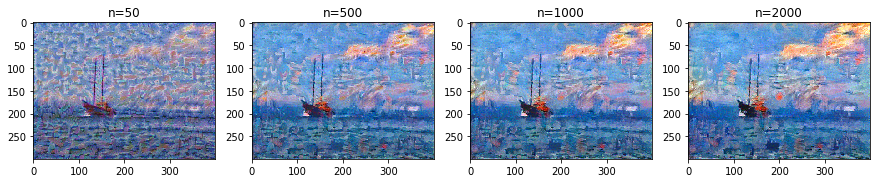

In [16]:
#%% plot figure
outpath = "good/demo_process/greececonv4_2dn_"
out_image1 = imageio.imread(outpath+"50.png")
out_image2 = imageio.imread(outpath+"500.png")
out_image3 = imageio.imread(outpath+"1000.png")
out_image4 = imageio.imread(outpath+"2000.png")
# imshow(out_image1)

fig, axs = plt.subplots(1, 4, figsize=(15,6))
axs[0].imshow(out_image1)
axs[0].set_title('n=50')
axs[1].imshow(out_image2)
axs[1].set_title('n=500')
axs[2].imshow(out_image3)
axs[2].set_title('n=1000')
axs[3].imshow(out_image4)
axs[3].set_title('n=2000')


## 5 - Batch process

In [9]:
#%% batch process under a foler
folder_in =  "demo_photos"
folder_out = "output"
image_S = "image_style\\Monet.jpg"
 
paths = glob.glob(os.path.join(folder_in, '*.jpg'))
paths.sort()

start_time = time.time()
for path in paths:
    print(path)
    temp = folder_in+'\\'
    image_C  = path.replace(temp, "")
    print(image_C)
#     NST_main(model, folder_in, folder_out, image_C, image_S, S_weit ='dn', N = 2000)
    elapsed_time = time.time() - start_time
    print('elapsed_time:', elapsed_time)


demo_photos\A2.jpg
A2.jpg
elapsed_time: 0.0009961128234863281
demo_photos\cat3.jpg
cat3.jpg
elapsed_time: 0.0009961128234863281
demo_photos\greece.jpg
greece.jpg
elapsed_time: 0.0009961128234863281
demo_photos\morroco.jpg
morroco.jpg
elapsed_time: 0.0009961128234863281
demo_photos\portogal.jpg
portogal.jpg
elapsed_time: 0.0009961128234863281
demo_photos\portogal2.jpg
portogal2.jpg
elapsed_time: 0.0009961128234863281
demo_photos\prage.jpg
prage.jpg
elapsed_time: 0.0019931793212890625
demo_photos\shahara.jpg
shahara.jpg
elapsed_time: 0.0019931793212890625
demo_photos\tower.jpg
tower.jpg
elapsed_time: 0.0019931793212890625


Finally, after waiting seval hours, we got some nice images by learning from the master Monet!


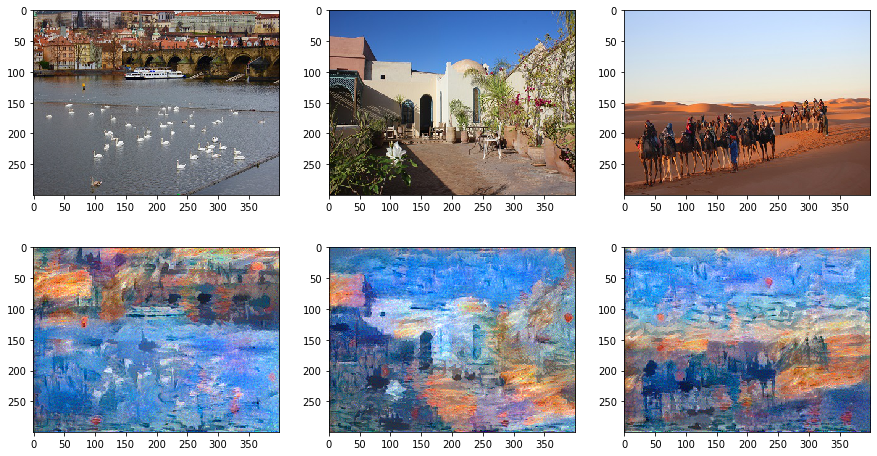

In [10]:
#%% comparing hyper-parameters amonst 6 figs
demopath = "demo_photos/"
outpath = "good/"
out_image00 = imageio.imread(demopath+"prage.jpg")
out_image01 = imageio.imread(demopath+"morroco.jpg")
out_image02 = imageio.imread(demopath+"shahara.jpg")
out_image10 = imageio.imread(outpath+"prageconv4_2dn_2000.png")
out_image11 = imageio.imread(outpath+"morrococonv4_2dn_2000.png")
out_image12 = imageio.imread(outpath+"shaharaconv4_2dn_2000.png")

# imshow(out_image1)

fig, axs = plt.subplots(2, 3, figsize=(15,8))
axs[0, 0].imshow(out_image00)
axs[0, 1].imshow(out_image01)
axs[0, 2].imshow(out_image02)
axs[1, 0].imshow(out_image10)
axs[1, 1].imshow(out_image11)
axs[1, 2].imshow(out_image12)

### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
